In [1]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
data_path = '/home/shellyg2324/data_clean.csv'
labels_path = '/home/shellyg2324/processedLabels.csv'

In [4]:
def load_pose_landmarks(csv_path, labels_path):
    """Loads a CSV created by MoveNetPreprocessor.
    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    labels = pd.read_csv(labels_path, header=None)
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    df_to_process.pop('class_name')
    df_to_process.pop('class_no')

    # Extract the labels
    y = labels
    classes = range(8)

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)
    
    return X, y, classes, dataframe

In [5]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(data_path, labels_path)
print(X.shape, y.shape)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)

# 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

#print(X_train.shape, X_val.shape, X_test.shape)

#60/20/20
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

FileNotFoundError: [Errno 2] No such file or directory: '/home/shellyg2324/data_clean.csv'

In [48]:
!pip install torchsampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 49.5 MB/s eta 0:00:0000:0100:01


In [63]:
print("TRAIN DISTRIBUTION")

sample_dist = []
for i in range(1,8):
    
    num_i = 0
    for sample in y_train:
            if tf.argmax(sample) == i:
                num_i+=1
    dist = num_i/len(y_train)
    print(f"{i}: {dist}")
    sample_dist.append(dist)


print("\nTEST DISTRIBUTION")
for i in range(1,8):
    
    num_i = 0
    for sample in y_test:
            if tf.argmax(sample) == i:
                num_i+=1

    dist = num_i/len(y_test)
    print(f"{i}: {dist}")
    #sample_dist.append(dist)

TRAIN DISTRIBUTION
1: 0.5123829953198128
2: 0.24015210608424337
3: 0.11008190327613104
4: 0.044266770670826835
5: 0.02379095163806552
6: 0.008677847113884555
7: 0.06054992199687988

TEST DISTRIBUTION
1: 0.5101404056162246
2: 0.25195007800312014
3: 0.10218408736349453
4: 0.039781591263650544
5: 0.035101404056162244
6: 0.0070202808112324495
7: 0.05382215288611544


In [70]:
sample_dist = sample_dist/np.linalg.norm(sample_dist)
weight_balanced= [1/s for s in sample_dist]

print(sample_dist)
print(weight_balanced)
#weight_balanced = weight_balanced/np.linalg.norm(weight_balanced)
#print(weight_balanced)
#print(np.sum(weight_balanced))

[0.88055143 0.41271136 0.18918032 0.07607428 0.04088574 0.01491324
 0.10405755]
[1.135652005397082, 2.4230009290952763, 5.285962168610864, 13.145046890664462, 24.458406919515024, 67.05450885799625, 9.610066486894793]


In [9]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

        It is the maximum of two values:
        * Torso size multiplied by `torso_size_multiplier`
        * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

def no_normalization(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    landmarks = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Flatten the landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks[:, :, :2])

    return embedding

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## No normalizing at all

In [26]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = no_normalization(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 51)]              0         
                                                                 
 reshape_3 (Reshape)         (None, 17, 3)             0         
                                                                 
 tf.__operators__.getitem_3   (None, 17, 2)            0         
 (SlicingOpLambda)                                               
                                                                 
 flatten_3 (Flatten)         (None, 34)                0         
                                                                 
 dense_9 (Dense)             (None, 128)               4480      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                           

In [27]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path` = "weights.best.hdf5"

checkpoint_path = "weights.best.801010split"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training


history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
618/641 [===========================>..] - ETA: 0s - loss: 2.2475 - accuracy: 0.4188
Epoch 1: val_accuracy improved from -inf to 0.50468, saving model to weights.best.801010split
INFO:tensorflow:Assets written to: weights.best.801010split/assets
641/641 [==============================] - 3s 3ms/step - loss: 2.2219 - accuracy: 0.4208 - val_loss: 1.3811 - val_accuracy: 0.5047
Epoch 2/200
619/641 [===========================>..] - ETA: 0s - loss: 1.4182 - accuracy: 0.5080
Epoch 2: val_accuracy improved from 0.50468 to 0.52808, saving model to weights.best.801010split
INFO:tensorflow:Assets written to: weights.best.801010split/assets
641/641 [==============================] - 2s 4ms/step - loss: 1.4164 - accuracy: 0.5084 - val_loss: 1.1882 - val_accuracy: 0.5281
Epoch 3/200
634/641 [============================>.] - ETA: 0s - loss: 1.3249 - accuracy: 0.5307
Epoch 3: val_accuracy improved from 0.52808 to 0.59360, saving model to weights.best.801010split
INFO:tensorflow:Assets wr

KeyboardInterrupt: 

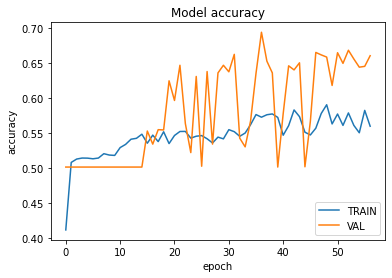

In [15]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [16]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

81/81 [==============================] - 0s 1ms/step - loss: 1.0659 - accuracy: 0.6611


Confusion matrix, without normalization


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
               precision    recall  f1-score   support

           1       0.84      0.88      0.86      1301
           2       0.46      0.82      0.59       663
           3       0.00      0.00      0.00       254
           4       0.00      0.00      0.00       101
           5       0.00      0.00      0.00        83
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00       142

    accuracy                           0.66      2564
   macro avg       0.19      0.24      0.21      2564
weighted avg       0.54      0.66      0.59      2564



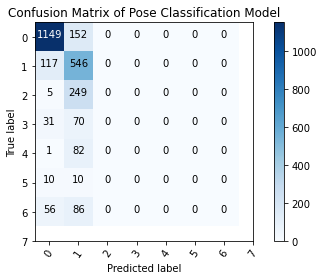

In [18]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

## Normalize everything

In [28]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_4 (Reshape)            (None, 17, 3)        0           ['input_5[0][0]']                
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 17, 2)       0           ['reshape_4[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_7 (TFOpLam  (None, 2)           0           ['tf.__operators__.getitem_

 )                                                                                                
                                                                                                  
 tf.math.multiply_10 (TFOpLambd  (None, 2)           0           ['tf.compat.v1.gather_10[0][0]'] 
 a)                                                                                               
                                                                                                  
 tf.broadcast_to_2 (TFOpLambda)  (None, 17, 2)       0           ['tf.expand_dims_2[0][0]',       
                                                                  'tf.compat.v1.floor_div_2[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_5 (TFOpLa  (None, 2)           0           ['tf.math.multiply_11[0][0]',    
 mbda)    

In [29]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path = "weights.best.hdf5"

checkpoint_path = "weights.best.801010split"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
641/641 [==============================] - ETA: 0s - loss: 1.0476 - accuracy: 0.6565
Epoch 1: val_accuracy improved from -inf to 0.76209, saving model to weights.best.801010split
INFO:tensorflow:Assets written to: weights.best.801010split/assets
641/641 [==============================] - 4s 5ms/step - loss: 1.0476 - accuracy: 0.6565 - val_loss: 0.7054 - val_accuracy: 0.7621
Epoch 2/200
630/641 [============================>.] - ETA: 0s - loss: 0.7819 - accuracy: 0.7543
Epoch 2: val_accuracy improved from 0.76209 to 0.78627, saving model to weights.best.801010split
INFO:tensorflow:Assets written to: weights.best.801010split/assets
641/641 [==============================] - 3s 5ms/step - loss: 0.7811 - accuracy: 0.7548 - val_loss: 0.6003 - val_accuracy: 0.7863
Epoch 3/200
621/641 [============================>.] - ETA: 0s - loss: 0.6966 - accuracy: 0.7719
Epoch 3: val_accuracy improved from 0.78627 to 0.81513, saving model to weights.best.801010split
INFO:tensorflow:Assets wr

Epoch 23/200
633/641 [============================>.] - ETA: 0s - loss: 0.4810 - accuracy: 0.8455
Epoch 23: val_accuracy did not improve from 0.89002
641/641 [==============================] - 1s 2ms/step - loss: 0.4812 - accuracy: 0.8453 - val_loss: 0.3697 - val_accuracy: 0.8861
Epoch 24/200
630/641 [============================>.] - ETA: 0s - loss: 0.4699 - accuracy: 0.8424
Epoch 24: val_accuracy did not improve from 0.89002
641/641 [==============================] - 1s 2ms/step - loss: 0.4733 - accuracy: 0.8411 - val_loss: 0.3517 - val_accuracy: 0.8877
Epoch 25/200
637/641 [============================>.] - ETA: 0s - loss: 0.4646 - accuracy: 0.8440
Epoch 25: val_accuracy did not improve from 0.89002
641/641 [==============================] - 1s 2ms/step - loss: 0.4648 - accuracy: 0.8443 - val_loss: 0.3589 - val_accuracy: 0.8900
Epoch 26/200
639/641 [============================>.] - ETA: 0s - loss: 0.4649 - accuracy: 0.8404
Epoch 26: val_accuracy did not improve from 0.89002
641/641

Epoch 78/200
623/641 [============================>.] - ETA: 0s - loss: 0.3799 - accuracy: 0.8761
Epoch 78: val_accuracy did not improve from 0.91888
641/641 [==============================] - 1s 2ms/step - loss: 0.3786 - accuracy: 0.8769 - val_loss: 0.2662 - val_accuracy: 0.9119
Epoch 79/200
632/641 [============================>.] - ETA: 0s - loss: 0.3713 - accuracy: 0.8793
Epoch 79: val_accuracy did not improve from 0.91888
641/641 [==============================] - 1s 2ms/step - loss: 0.3727 - accuracy: 0.8787 - val_loss: 0.2704 - val_accuracy: 0.9181
Epoch 80/200
624/641 [============================>.] - ETA: 0s - loss: 0.3618 - accuracy: 0.8788
Epoch 80: val_accuracy did not improve from 0.91888
641/641 [==============================] - 1s 2ms/step - loss: 0.3638 - accuracy: 0.8780 - val_loss: 0.2698 - val_accuracy: 0.9134
Epoch 81/200
633/641 [============================>.] - ETA: 0s - loss: 0.3764 - accuracy: 0.8758
Epoch 81: val_accuracy did not improve from 0.91888
641/641

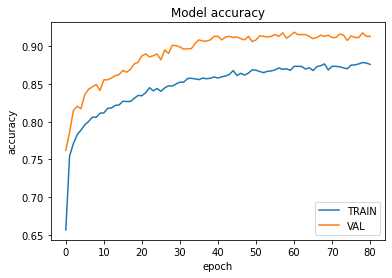

In [30]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [31]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

41/41 [==============================] - 0s 2ms/step - loss: 0.7723 - accuracy: 0.7309


Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

           1       0.98      0.71      0.82       654
           2       0.62      0.87      0.72       323
           3       0.57      0.85      0.68       131
           4       0.49      0.41      0.45        51
           5       0.76      0.42      0.54        45
           6       0.33      1.00      0.50         9
           7       0.49      0.45      0.47        69

    accuracy                           0.73      1282
   macro avg       0.61      0.67      0.60      1282
weighted avg       0.79      0.73      0.74      1282



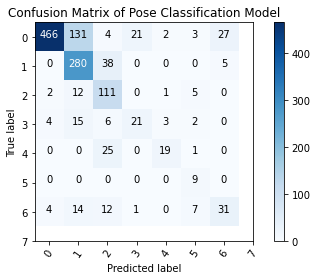

In [32]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

## No normalizing size

In [15]:
def normalize_pose_landmarks_norescale(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    return landmarks
def landmarks_to_embedding_norescale(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks_norescale(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

In [16]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding_norescale(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model2 = keras.Model(inputs, outputs)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 17, 3)        0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 17, 2)       0           ['reshape_1[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_9 (TFOpLam  (None, 2)           0           ['tf.__operators__.getitem_

In [17]:
model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.801010splitnonormsize"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history2 = model2.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
629/641 [============================>.] - ETA: 0s - loss: 1.7940 - accuracy: 0.5428
Epoch 1: val_accuracy improved from -inf to 0.77301, saving model to weights.best.801010splitnonormsize
INFO:tensorflow:Assets written to: weights.best.801010splitnonormsize/assets
641/641 [==============================] - 3s 4ms/step - loss: 1.7840 - accuracy: 0.5437 - val_loss: 0.8157 - val_accuracy: 0.7730
Epoch 2/200
629/641 [============================>.] - ETA: 0s - loss: 1.0155 - accuracy: 0.6830
Epoch 2: val_accuracy improved from 0.77301 to 0.78081, saving model to weights.best.801010splitnonormsize
INFO:tensorflow:Assets written to: weights.best.801010splitnonormsize/assets
641/641 [==============================] - 2s 4ms/step - loss: 1.0137 - accuracy: 0.6838 - val_loss: 0.6618 - val_accuracy: 0.7808
Epoch 3/200
625/641 [============================>.] - ETA: 0s - loss: 0.8573 - accuracy: 0.7327
Epoch 3: val_accuracy improved from 0.78081 to 0.80577, saving model to weights.be

Epoch 24/200
617/641 [===========================>..] - ETA: 0s - loss: 0.5336 - accuracy: 0.8319
Epoch 24: val_accuracy did not improve from 0.89236
641/641 [==============================] - 2s 2ms/step - loss: 0.5367 - accuracy: 0.8310 - val_loss: 0.3725 - val_accuracy: 0.8807
Epoch 25/200
617/641 [===========================>..] - ETA: 0s - loss: 0.5416 - accuracy: 0.8249
Epoch 25: val_accuracy did not improve from 0.89236
641/641 [==============================] - 1s 2ms/step - loss: 0.5446 - accuracy: 0.8239 - val_loss: 0.3711 - val_accuracy: 0.8900
Epoch 26/200
623/641 [============================>.] - ETA: 0s - loss: 0.5356 - accuracy: 0.8253
Epoch 26: val_accuracy did not improve from 0.89236
641/641 [==============================] - 1s 2ms/step - loss: 0.5358 - accuracy: 0.8260 - val_loss: 0.3606 - val_accuracy: 0.8900
Epoch 27/200
630/641 [============================>.] - ETA: 0s - loss: 0.5210 - accuracy: 0.8364
Epoch 27: val_accuracy did not improve from 0.89236
641/641

623/641 [============================>.] - ETA: 0s - loss: 0.4622 - accuracy: 0.8529
Epoch 79: val_accuracy did not improve from 0.90952
641/641 [==============================] - 1s 2ms/step - loss: 0.4654 - accuracy: 0.8531 - val_loss: 0.3107 - val_accuracy: 0.9072
Epoch 80/200
630/641 [============================>.] - ETA: 0s - loss: 0.4485 - accuracy: 0.8566
Epoch 80: val_accuracy did not improve from 0.90952
641/641 [==============================] - 1s 2ms/step - loss: 0.4477 - accuracy: 0.8567 - val_loss: 0.3044 - val_accuracy: 0.9056
Epoch 81/200
633/641 [============================>.] - ETA: 0s - loss: 0.4534 - accuracy: 0.8514
Epoch 81: val_accuracy did not improve from 0.90952
641/641 [==============================] - 1s 2ms/step - loss: 0.4531 - accuracy: 0.8506 - val_loss: 0.2878 - val_accuracy: 0.9095
Epoch 82/200
635/641 [============================>.] - ETA: 0s - loss: 0.4473 - accuracy: 0.8563
Epoch 82: val_accuracy did not improve from 0.90952
641/641 [===========

Epoch 108/200
640/641 [============================>.] - ETA: 0s - loss: 0.4314 - accuracy: 0.8604
Epoch 108: val_accuracy did not improve from 0.91498
641/641 [==============================] - 1s 2ms/step - loss: 0.4319 - accuracy: 0.8603 - val_loss: 0.2965 - val_accuracy: 0.9041
Epoch 109/200
632/641 [============================>.] - ETA: 0s - loss: 0.4417 - accuracy: 0.8638
Epoch 109: val_accuracy did not improve from 0.91498
641/641 [==============================] - 1s 2ms/step - loss: 0.4403 - accuracy: 0.8641 - val_loss: 0.2806 - val_accuracy: 0.9095


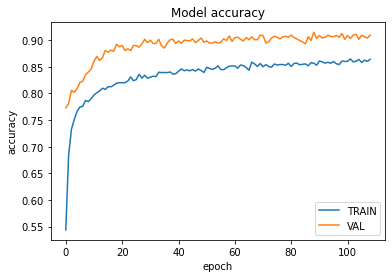

In [18]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [19]:
loss, accuracy = model2.evaluate(X_test, y_test)

41/41 [==============================] - 0s 1ms/step - loss: 0.3372 - accuracy: 0.8869


Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

           1       0.98      0.68      0.80       654
           2       0.62      0.87      0.72       323
           3       0.57      0.85      0.68       131
           4       0.35      0.45      0.40        51
           5       0.80      0.36      0.49        45
           6       0.36      1.00      0.53         9
           7       0.47      0.48      0.47        69

    accuracy                           0.72      1282
   macro avg       0.59      0.67      0.59      1282
weighted avg       0.78      0.72      0.72      1282



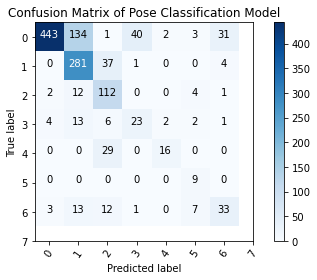

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

## No normalizing position

In [19]:
def normalize_pose_landmarks_noreposition(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
   # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks
def landmarks_to_embedding_norescale(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks_noreposition(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

In [20]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding_norescale(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model2 = keras.Model(inputs, outputs)
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 17, 3)        0           ['input_3[0][0]']                
                                                                                                  
 tf.__operators__.getitem_2 (Sl  (None, 17, 2)       0           ['reshape_2[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_4 (TFOpLam  (None, 2)           0           ['tf.__operators__.getitem_

 tf.math.reduce_max (TFOpLambda  ()                  0           ['tf.compat.v1.norm_1[0][0]']    
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   ()                   0           ['tf.math.multiply_6[0][0]',     
                                                                  'tf.math.reduce_max[0][0]']     
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 17, 2)        0           ['tf.__operators__.getitem_2[0][0
                                                                 ]',                              
                                                                  'tf.math.maximum[0][0]']        
                                                                                                  
 flatten_2

In [21]:
model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.801010splitnonormsize"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history2 = model2.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
467/481 [============================>.] - ETA: 0s - loss: 1.3760 - accuracy: 0.5186
Epoch 1: val_accuracy improved from -inf to 0.60140, saving model to weights.best.801010splitnonormsize
INFO:tensorflow:Assets written to: weights.best.801010splitnonormsize/assets
481/481 [==============================] - 3s 6ms/step - loss: 1.3702 - accuracy: 0.5202 - val_loss: 1.0453 - val_accuracy: 0.6014
Epoch 2/200
461/481 [===========================>..] - ETA: 0s - loss: 1.0469 - accuracy: 0.6430
Epoch 2: val_accuracy improved from 0.60140 to 0.70164, saving model to weights.best.801010splitnonormsize
INFO:tensorflow:Assets written to: weights.best.801010splitnonormsize/assets
481/481 [==============================] - 2s 5ms/step - loss: 1.0398 - accuracy: 0.6446 - val_loss: 0.8716 - val_accuracy: 0.7016
Epoch 3/200
459/481 [===========================>..] - ETA: 0s - loss: 0.9586 - accuracy: 0.6811
Epoch 3: val_accuracy improved from 0.70164 to 0.71997, saving model to weights.be

Epoch 25/200
465/481 [============================>.] - ETA: 0s - loss: 0.7471 - accuracy: 0.7505
Epoch 25: val_accuracy improved from 0.77535 to 0.78120, saving model to weights.best.801010splitnonormsize
INFO:tensorflow:Assets written to: weights.best.801010splitnonormsize/assets
481/481 [==============================] - 2s 5ms/step - loss: 0.7481 - accuracy: 0.7493 - val_loss: 0.6493 - val_accuracy: 0.7812
Epoch 26/200
462/481 [===========================>..] - ETA: 0s - loss: 0.7438 - accuracy: 0.7495
Epoch 26: val_accuracy did not improve from 0.78120
481/481 [==============================] - 1s 3ms/step - loss: 0.7432 - accuracy: 0.7499 - val_loss: 0.6505 - val_accuracy: 0.7808
Epoch 27/200
458/481 [===========================>..] - ETA: 0s - loss: 0.7321 - accuracy: 0.7484
Epoch 27: val_accuracy improved from 0.78120 to 0.78510, saving model to weights.best.801010splitnonormsize
INFO:tensorflow:Assets written to: weights.best.801010splitnonormsize/assets
481/481 [=============

INFO:tensorflow:Assets written to: weights.best.801010splitnonormsize/assets
481/481 [==============================] - 3s 6ms/step - loss: 0.6940 - accuracy: 0.7609 - val_loss: 0.6148 - val_accuracy: 0.7964
Epoch 51/200
464/481 [===========================>..] - ETA: 0s - loss: 0.6887 - accuracy: 0.7597
Epoch 51: val_accuracy did not improve from 0.79641
481/481 [==============================] - 1s 2ms/step - loss: 0.6907 - accuracy: 0.7590 - val_loss: 0.6016 - val_accuracy: 0.7952
Epoch 52/200
459/481 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.7635
Epoch 52: val_accuracy improved from 0.79641 to 0.79758, saving model to weights.best.801010splitnonormsize
INFO:tensorflow:Assets written to: weights.best.801010splitnonormsize/assets
481/481 [==============================] - 2s 5ms/step - loss: 0.6949 - accuracy: 0.7617 - val_loss: 0.6133 - val_accuracy: 0.7976
Epoch 53/200
456/481 [===========================>..] - ETA: 0s - loss: 0.6799 - accuracy: 0.7656

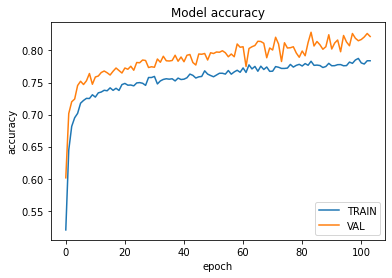

In [22]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [23]:
loss, accuracy = model2.evaluate(X_test, y_test)

81/81 [==============================] - 0s 1ms/step - loss: 0.8586 - accuracy: 0.6868


Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

           1       0.84      0.88      0.86      1301
           2       0.46      0.82      0.59       663
           3       0.00      0.00      0.00       254
           4       0.00      0.00      0.00       101
           5       0.00      0.00      0.00        83
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00       142

    accuracy                           0.66      2564
   macro avg       0.19      0.24      0.21      2564
weighted avg       0.54      0.66      0.59      2564



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


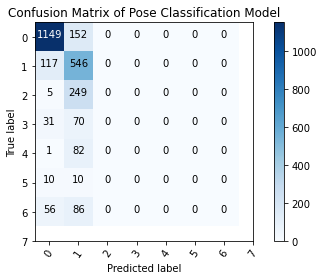

In [24]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))